In [1]:
import numpy as np, pandas as pd, time, os, itertools, subprocess, scipy as sp, re
import seaborn; seaborn.set_style('whitegrid')
import matplotlib.pyplot as plt, importlib
import scipy.sparse
import utils, diffmap as dm#, scanpy as sc
import sklearn.metrics

#data_pfx = '/oak/stanford/groups/akundaje/abalsubr/search_ui/'
data_pfx = '/Users/akshay/github/encode-ui-sandbox/data/'

In [2]:
importlib.reload(utils)
experiments_core = pd.DataFrame.from_csv("data/ENCODE2018Core.tsv", index_col=None, sep='\t')
experiments_sparse = pd.DataFrame.from_csv("data/ENCODE2018Sparse.tsv", index_col=None, sep='\t')
experiments_sparse = experiments_sparse.rename(columns={"Accession_x": "Accession"})
experiments = pd.concat((experiments_core, experiments_sparse))

/Users/akshay/anaconda3/envs/encode_ui/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/Users/akshay/anaconda3/envs/encode_ui/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
# Reorder experiments
experiments_old_main = pd.DataFrame.from_csv("data/ENCODE_Tracks.txt", header=None, index_col=None, sep='\t')
experiments_old_supp = pd.DataFrame.from_csv("data/ENCODE_Supp_Tracks.txt", header=None, index_col=None, sep='\t')
experiments_old = pd.concat((experiments_old_main, experiments_old_supp))

real_order = np.core.defchararray.add(np.array(experiments_old.iloc[:,0]).astype(str), np.array(experiments_old.iloc[:,1]).astype(str))
new_order = np.core.defchararray.add(np.array(experiments['Biosample Index']).astype(str), np.array(experiments['Assay']).astype(str))
rt = np.intersect1d(real_order, new_order, return_indices=True)
real_ndx_to_new = dict(zip(rt[1], rt[2]))
ndxarr = sorted(real_ndx_to_new.items(), key=lambda x: x[0])
new_ndces = np.array(ndxarr)[:,1]
new_exp = experiments.iloc[new_ndces,:]

# new_exp.to_csv('data/reordered_experiments.csv', sep='\t', index=None)

/Users/akshay/anaconda3/envs/encode_ui/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/Users/akshay/anaconda3/envs/encode_ui/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
import app_config
point_names = np.array(new_exp[app_config.params['display_ID_var']])#(new_exp['Experiment_name'] == 'ChIP-seq_REST_K562')[0][0]
graph_adj = sp.sparse.load_npz(app_config.params['adj_mat_path'])

KeyError: 'Experiment_name'

In [38]:
exp_ndx = np.where(point_names == 'CAGE_plus_strand_SK-N-SH')[0][0]
print(exp_ndx)
nbrs = 

1


# Experimental embeddings

In [6]:
#experiments.to_csv('data/experiments.csv', sep='\t', index=None)
experiments = pd.DataFrame.from_csv(
    "data/reordered_experiments.csv", index_col=None, sep='\t')

/Users/akshay/anaconda3/envs/encode_ui/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


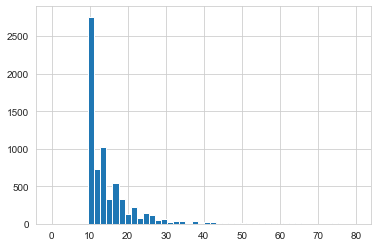

In [7]:
itime = time.time()
# eemb = np.load('data/experiment_embedding.npz')['arr_0']
# print(time.time() - itime)
# sparse_adj = utils.make_nn_graph(eemb, k=10)
# print(time.time() - itime)

#scipy.sparse.save_npz(data_pfx + 'encode3_6870_10nn.npz', sparse_adj)
sparse_adj = scipy.sparse.load_npz(data_pfx + 'encode3_6870_10nn.npz')
plt.hist(np.ravel(sparse_adj.sum(axis=0)), bins=50, range=(0,80))
plt.show()

In [9]:
assay_names = [x.split('_signal')[0] for x in experiments['Assay'] if '_signal'  in x]

In [11]:
len(assay_names)

6870

In [45]:
from umap import UMAP
itime = time.time()
X_umap = UMAP(200, random_state=111).fit_transform(eemb)
print(time.time() - itime)

experiments['umap_raw_X'] = X_umap[:,0]
experiments['umap_raw_Y'] = X_umap[:,1]

/users/abalsubr/anaconda2/envs/scs3/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda2/envs/scs3/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


66.47995853424072


In [52]:
itime = time.time()
X_diffmap_100 = dm.diffmap_proj(sparse_adj, n_dims=100)
print(time.time() - itime)

101 dimensions contain about 0.95 fraction of the variance in the first 2000 dimensions (Diffusion time = 19.126298161980007)
310.04082918167114


In [53]:
itime = time.time()
X_umap_2 = UMAP(200, random_state=111).fit_transform(X_diffmap_100)
print(time.time() - itime)
experiments['umap_graph_X'] = X_umap_2[:,0]
experiments['umap_graph_Y'] = X_umap_2[:,1]

/users/abalsubr/anaconda2/envs/scs3/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda2/envs/scs3/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


54.893067359924316


In [5]:
assaynames = [x.split('_signal')[0] for x in experiments['Assay'] if '_signal'  in x]
newnames = []
for i in range(len(assaynames)):
    a = assaynames[i]
    newnames.append("{}_{}".format(a, experiments['Biosample'][i]))
experiments['Experiment_name'] = newnames

In [18]:
plot_data_df = experiments
assay_names = [x.split('_signal')[0] for x in plot_data_df['Assay'] if '_signal'  in x]
cell_types = np.array(plot_data_df['Biosample'])

In [8]:
assaynames2 = [x.split('_signal')[1] for x in experiments['Assay'] if '_signal'  in x]

In [25]:
np.unique(assaynames2, return_counts=True)

(array(['', '_of_all_reads', '_p-value'], dtype='<U13'),
 array([ 622, 2610, 3638]))